# Predictive Analysis

### Load the required libraries


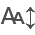

In [1]:
import pickle
import os
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

# Statistical libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

# Visualization libraries
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis libraries
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

import scipy.stats as stats
from scipy.stats import boxcox

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# Supress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# Custom Function for creating a data dictionary 
def data_dictionary(df):
    # Create a data dictionary of the data-types
    datadict = pd.DataFrame(df.dtypes)
    # Rename the Data Type Column 
    datadict = datadict.rename(columns={0:'DataType'})
    # Add a count of missing values
    datadict['MissingVal'] = df.isnull().sum()
    # Add the number of unique values for each attribute (objects count the levels)
    datadict['NUnique']=df.nunique()
    # Add a count for each attribute
    datadict['Count']=df.count()        
    return (datadict)


### Load the Required Data

In [3]:
# Create a list of pickle files to load
pickle_files = ['all_weather_data.pkl', 
                'all_weather_data_daily.pkl', 
                #'all_weather_data_pivot.pkl', 
                'avg_NO2_daily.pkl', 
                'fips_site_locations.pkl']

# Open each pickle file and load the data based on the file name

for file in pickle_files:
    with open(file, 'rb') as f:
        if file == 'all_weather_data.pkl':
            all_weather_data = pickle.load(f)
        elif file == 'all_weather_data_daily.pkl':
            all_weather_data_daily = pickle.load(f)
        elif file == 'avg_NO2_daily.pkl':
            avg_NO2_daily = pickle.load(f)
        elif file == 'fips_site_locations.pkl':
            fips_site_locations = pickle.load(f)


In [ ]:
# Group the NO2 data into two groups: pre-COVID and post-COVID
covid_date = '2020-03-15'
# Reset the index to a column
avg_NO2_daily.reset_index(inplace=True)
avg_NO2_daily['COVID'] = np.where(avg_NO2_daily['date_local'] < covid_date, 'Pre-COVID', 'Post-COVID')

# Remove all rows with date_local >= covid_date + 1 year
avg_NO2_daily = avg_NO2_daily[avg_NO2_daily['date_local'] < '2021-03-15']


### Merge the Weather Data and the $NO_2$ Data

In [ ]:
# Merge the NO2 and weather data on fips, fips_site, metro_area and date_local
merged_data = pd.merge(avg_NO2_daily, all_weather_data_daily, on=['fips', 'fips_site', 'metro_area', 'date_local'], how='inner')
# Check the merged data
#print(merged_data.head())
# Check the merged data info
#print(merged_data.info()) 

# Set date_local as the index
merged_data.set_index('date_local', inplace=True)
# Check the merged data dictionary
print(data_dictionary(merged_data))


                      DataType  MissingVal  NUnique  Count
fips                    object           0       17  46798
fips_site               object           0       40  46798
latitude               float32           0       40  46798
longitude              float32           0       40  46798
NO2_concentration      float32           0    17939  46798
metro_area            category           0        5  46798
month_year           period[M]           0       51  46798
year                     int32           0        5  46798
week_of_year            UInt32           0       53  46798
day_of_year              int32           0      366  46798
day_of_week             object           0        7  46798
day_of_week_num          int32           0        7  46798
day_of_week_sin        float64           0        7  46798
day_of_week_cos        float64           0        7  46798
weekday                 object           0        2  46798
day_of_year_sin        float64           0      366  467

In [ ]:
# Drop barometric pressure and dew point columns
merged_data.drop(columns=['barometric_pressure', 'dew_point'], inplace=True)


In [ ]:
# Create a list of unique metro areas
metro_areas = avg_NO2_daily['metro_area'].unique()
# Sort the metro areas in alphabetical order
metro_areas = sorted(metro_areas)


In [8]:
# Group by metro area and year and count the number of rows in each group
grouped_data = merged_data.groupby(['metro_area', 'year']).size().reset_index(name='count')
# Check the grouped data
print(grouped_data)
# Check the grouped data info


     metro_area  year  count
0       Chicago  2017    925
1       Chicago  2018    973
2       Chicago  2019    411
3       Chicago  2020    473
4       Chicago  2021     70
5        Denver  2017   1904
6        Denver  2018   1739
7        Denver  2019   2081
8        Denver  2020   2096
9        Denver  2021    400
10  Los Angeles  2017   5281
11  Los Angeles  2018   5258
12  Los Angeles  2019   5768
13  Los Angeles  2020   5829
14  Los Angeles  2021   1215
15     New York  2017   2508
16     New York  2018   2312
17     New York  2019   1888
18     New York  2020    879
19     New York  2021    219
20   Washington  2017   1085
21   Washington  2018   1093
22   Washington  2019   1078
23   Washington  2020   1094
24   Washington  2021    219


### Feature Engineering

In [ ]:
# Take the log of the NO2 concentrations
merged_data['NO2_log'] = np.log(merged_data['NO2_concentration'])

# Take the log of the wind speed
merged_data['wind_speed_log'] = np.log(merged_data['wind_speed'])


Lambda for Chicago: 0.4602377842909455
Lambda for Denver: 0.6004956657811572
Lambda for Los Angeles: 0.213733993296415
Lambda for New York: 0.18967332604067144
Lambda for Washington: 0.08810904980978569


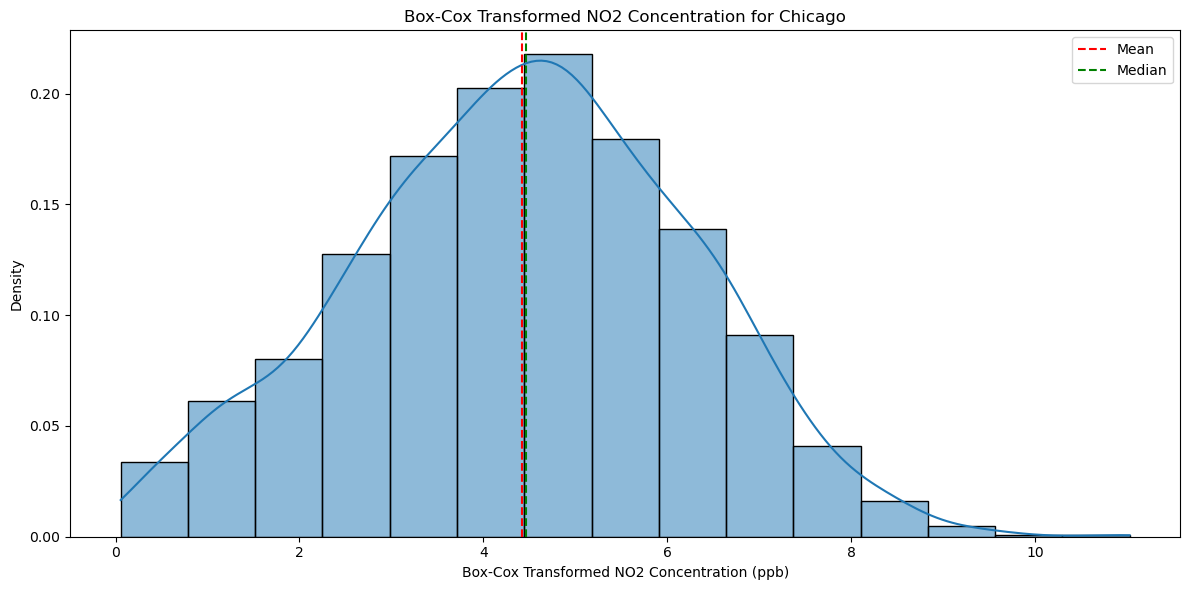

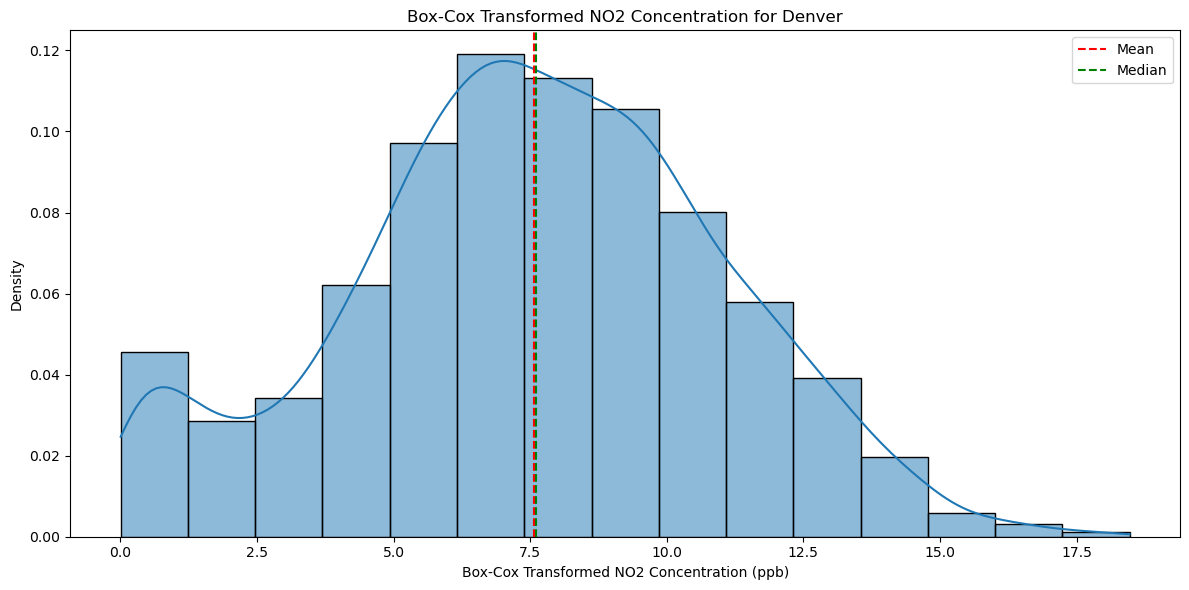

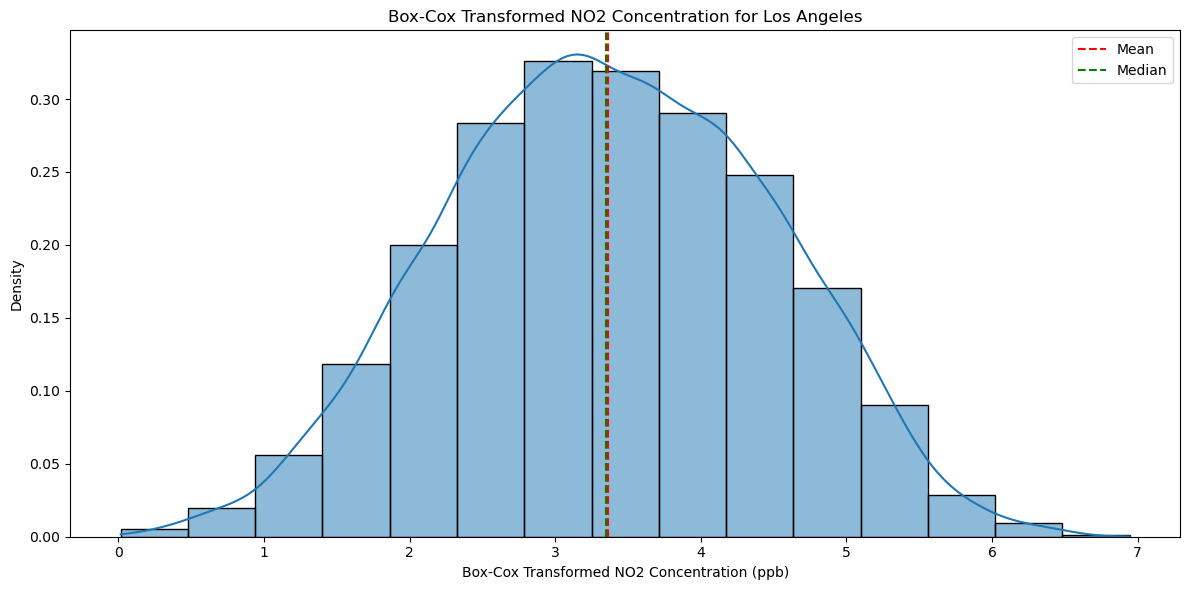

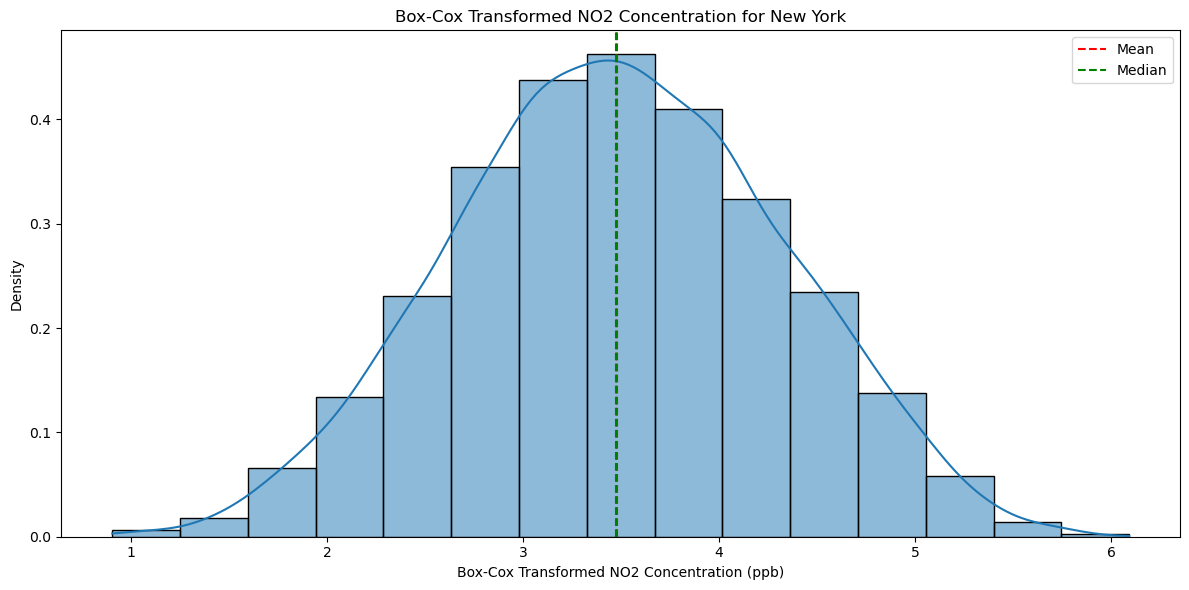

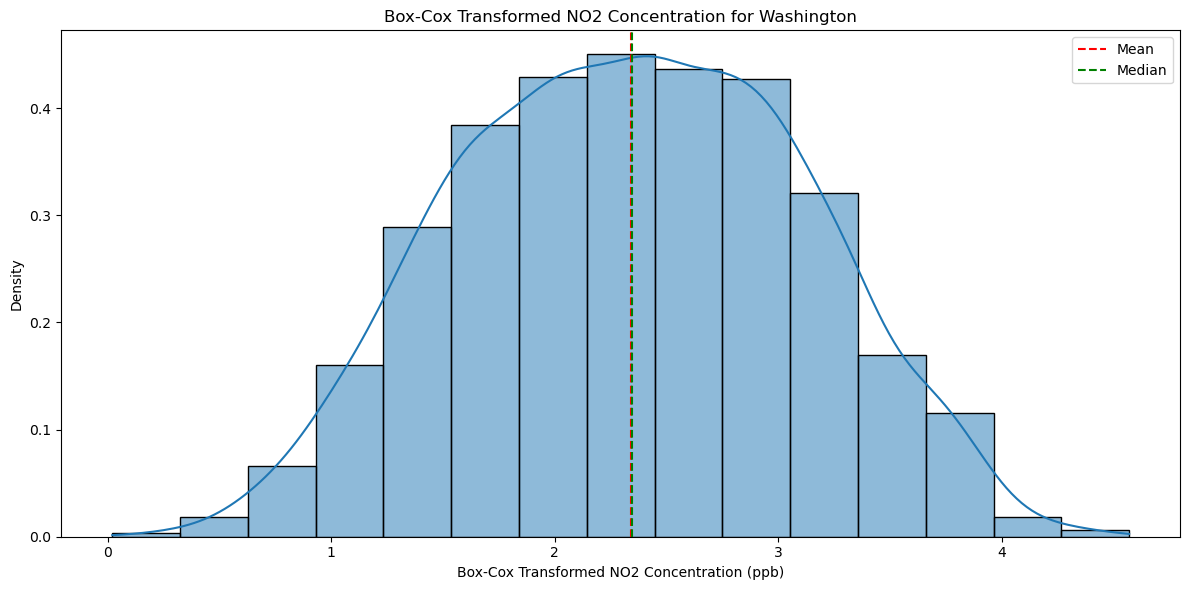

In [10]:
# Perform the Box-Cox transformation on the NO2 concentrations by metro area
merged_data['NO2_box_cox'] = np.nan
for metro_area in metro_areas:
    # Filter the data for the current metro area
    metro_data = merged_data[merged_data['metro_area'] == metro_area]
    # Perform the Box-Cox transformation
    merged_data.loc[merged_data['metro_area'] == metro_area, 'NO2_box_cox'], lmbda = boxcox(metro_data['NO2_concentration'])
    print(f'Lambda for {metro_area}: {lmbda}')
    # Plot the histogram of the Box-Cox transformed data
    plt.figure(figsize=(12, 6))
    sns.histplot(merged_data.loc[merged_data['metro_area'] == metro_area, 'NO2_box_cox'], bins=15, kde=True, stat='density')
    plt.ylabel('Density')
    plt.xlabel('Box-Cox Transformed NO2 Concentration (ppb)')
    plt.title(f'Box-Cox Transformed NO2 Concentration for {metro_area}')
    plt.axvline(merged_data.loc[merged_data['metro_area'] == metro_area, 'NO2_box_cox'].mean(), color='red', linestyle='--', label='Mean')
    plt.axvline(merged_data.loc[merged_data['metro_area'] == metro_area, 'NO2_box_cox'].median(), color='green', linestyle='--', label='Median')
    plt.legend()
    plt.tight_layout()


## Linear Regression Model using Pre-COVID data

### Define the Linear Regression Model

In [ ]:
# Dependent variable:
dependent_variable = 'NO2_log'

features = [dependent_variable, 
            'fips_site', 
            'day_of_week',
            'day_of_year_sin', 'day_of_year_cos', 
            'outdoor_temperature', 
            'relative_humidity',
            'wind_direction', 'wind_speed_log'
            ]

# Define the column transformer
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['fips_site', 'day_of_week']),
    ],
    remainder='passthrough'  # keep other columns
)

# Create a pipeline for the model
pipeline = Pipeline(steps=[
    ('preprocessor', transformer),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LinearRegression())
    #('model', RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True))
    #('model', LassoCV(alphas=[0.1, 1.0, 10.0], cv=5, random_state=998))
    #('model', ElasticNetCV(alphas=[0.1, 1.0, 10.0], cv=5, random_state=998))
])


### Example for one Metro Area

Missing values in each feature:
outdoor_temperature    95
relative_humidity      50
dtype: int64
Model data shape: (2275, 9)
Training data shape: (1820, 8)
Testing data shape: (455, 8)
Training target shape: (1820,)
Testing target shape: (455,)
Mean Squared Error: 0.121
Root Mean Squared Error: 0.347
R-squared: 0.600


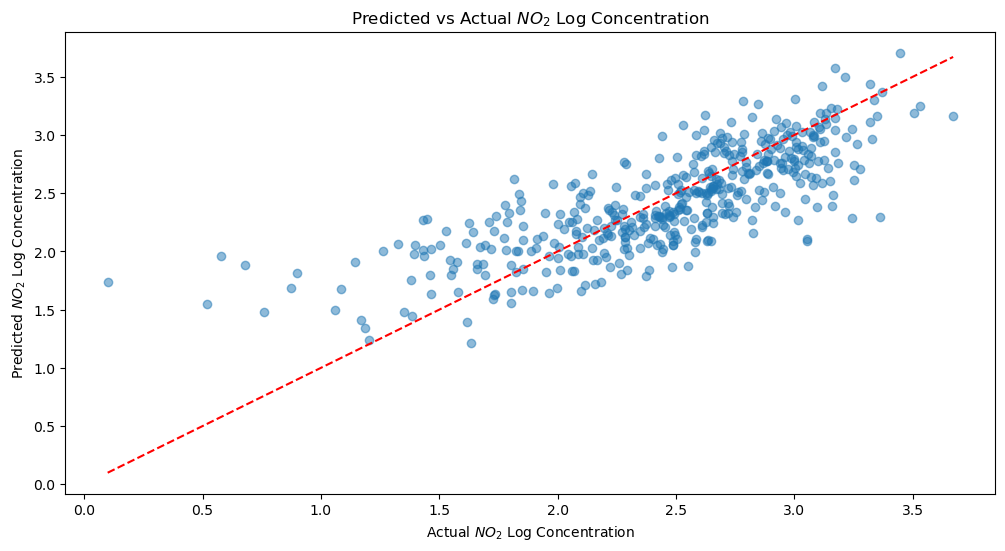

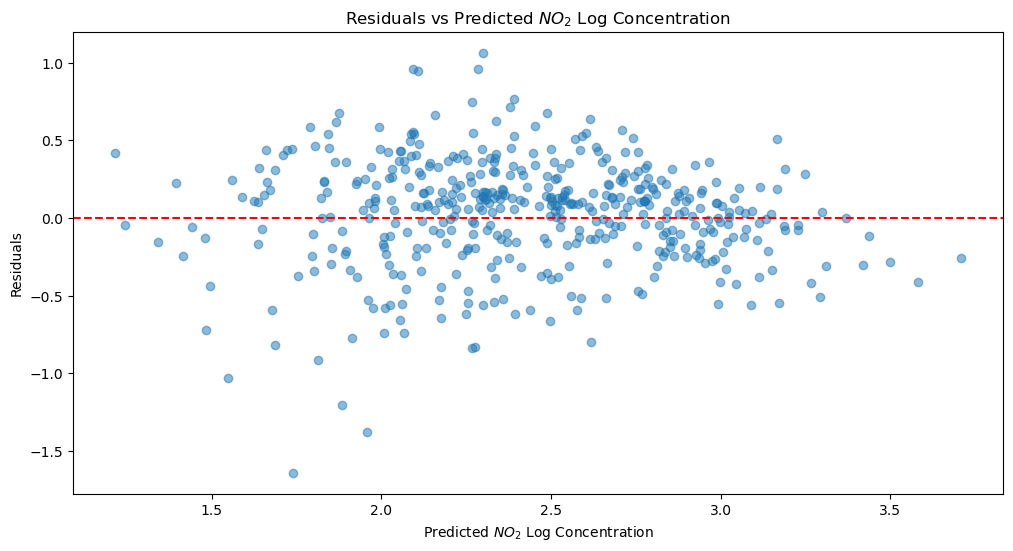

In [ ]:
metro_area_of_interest = 'Chicago'

merged_data_metro = merged_data[merged_data['metro_area'] == metro_area_of_interest]
model_data = merged_data_metro.copy()
model_data = model_data[model_data['COVID'] == 'Pre-COVID']

# Select feature of the model to train
model_data = model_data[features]

# Fill the missing values with interpolation
model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')

# Count the number of rows with missing values
missing_values = model_data.isnull().sum()

# Print the number of missing values for each feature
print('Missing values in each feature:')
print(missing_values[missing_values > 0])

# Drop na values
model_data = model_data.dropna()

# Print the size of the model data
print(f'Model data shape: {model_data.shape}')

# Select the dependent variable and independent variables
Y = model_data[dependent_variable]
X = model_data[features].drop(columns=[dependent_variable])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=998)

# Check the training and testing data shapes
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Training target shape: {y_train.shape}')
print(f'Testing target shape: {y_test.shape}')

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
# Calculate the mean squared error 
mse = mean_squared_error(y_test, y_pred)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
# Print the results
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(r'Predicted vs Actual $NO_2$ Log Concentration')
plt.xlabel(r'Actual $NO_2$ Log Concentration')
plt.ylabel(r'Predicted $NO_2$ Log Concentration')
plt.show()

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(r'Residuals vs Predicted $NO_2$ Log Concentration')
plt.xlabel(r'Predicted $NO_2$ Log Concentration')
plt.ylabel('Residuals')
plt.show()


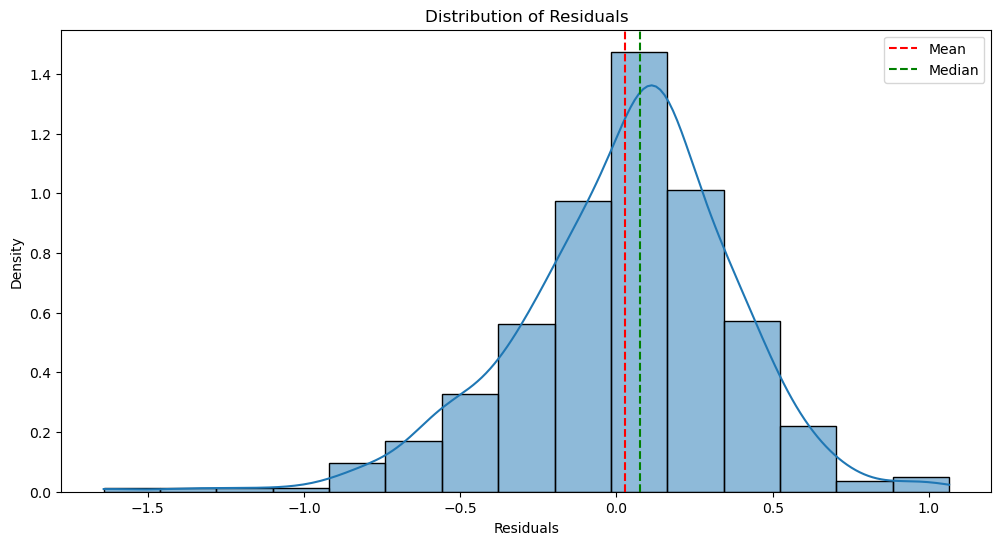

In [13]:
# Plot a distribution of the residuals
plt.figure(figsize=(12, 6))
sns.histplot(y_test - y_pred, bins=15, kde=True, stat='density')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.axvline((y_test - y_pred).mean(), color='red', linestyle='--', label='Mean')
plt.axvline((y_test - y_pred).median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.show()


In [14]:
# Perform the test for normality of residuals
residuals = y_test - y_pred
# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print(f'Shapiro-Wilk test statistic: {shapiro_test.statistic:.3f}, p-value: {shapiro_test.pvalue:.3f}')


Shapiro-Wilk test statistic: 0.972, p-value: 0.000


In [ ]:
# Prediction Data Frame
y_pred_df = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred_df.index = X_test.index
# Test Data Frame
y_test_df = pd.DataFrame(y_test)
y_test_df.index = X_test.index


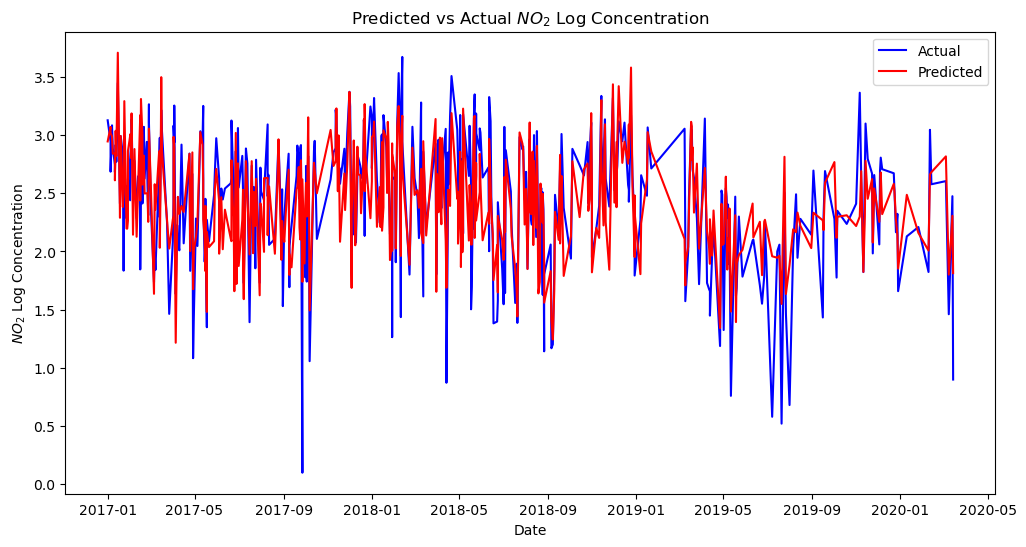

In [16]:
# Sort the index of the dataframes
y_pred_df.sort_index(inplace=True)
y_test_df.sort_index(inplace=True)

# Time series plot of predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_df.index, y_test_df, label='Actual', color='blue')
plt.plot(y_pred_df.index, y_pred_df['y_pred'], label='Predicted', color='red')
plt.title(r'Predicted vs Actual $NO_2$ Log Concentration')
plt.xlabel('Date')
plt.ylabel(r'$NO_2$ Log Concentration')
plt.legend()
plt.show()



Cross-validation RMSE: 0.374


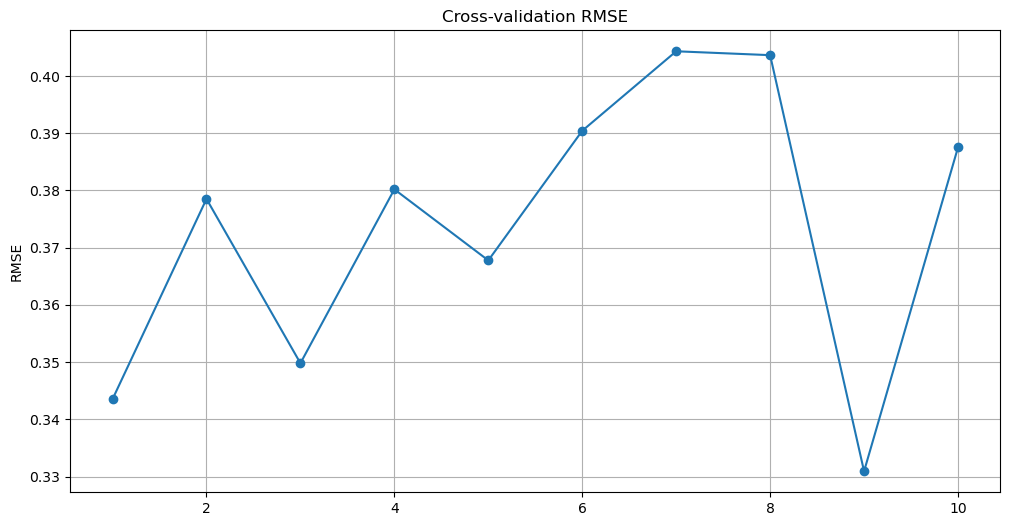

In [17]:
# Perform Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

cv = KFold(n_splits=10, shuffle=True, random_state=999)

cross_val_scores = cross_val_score(pipeline, X, Y, cv=cv, scoring='neg_mean_squared_error')
cross_val_rmse = np.sqrt(-cross_val_scores)

# Print the cross-validation results
print(f'Cross-validation RMSE: {cross_val_rmse.mean():.3f}')
# Plot the cross-validation results
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cross_val_rmse) + 1), cross_val_rmse, marker='o')
plt.title('Cross-validation RMSE')
plt.ylabel('RMSE')
#plt.xticks(range(1, len(cross_val_rmse) + 1), rotation=90)
plt.grid()
plt.show()


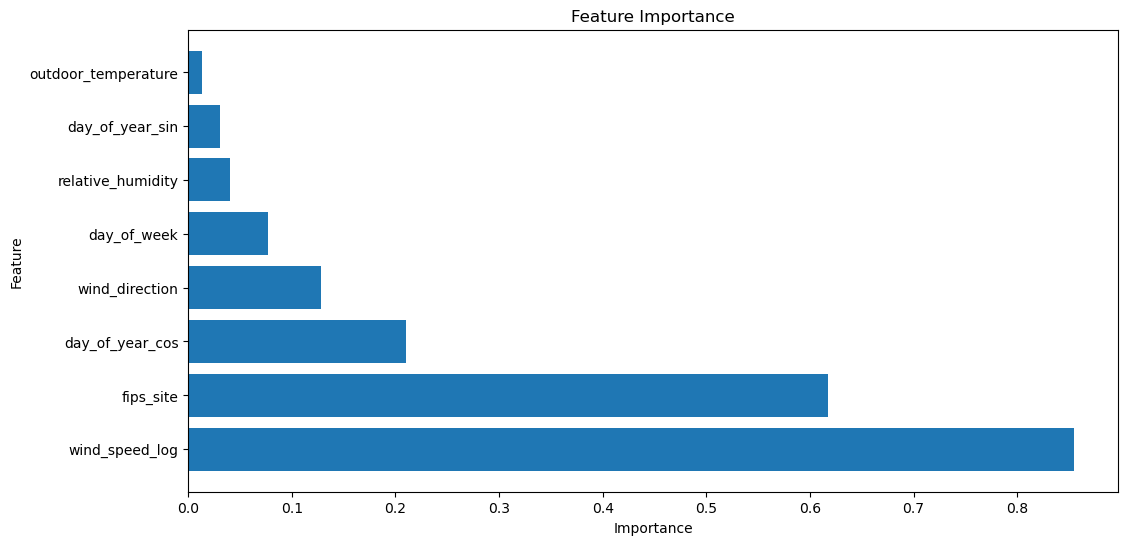

In [18]:
# Calculate the Feature Importance
from sklearn.inspection import permutation_importance
# Calculate the feature importance using permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=998)
# Get the feature names
feature_names = X_test.columns
# Create a DataFrame for the feature importance
importance_df = pd.DataFrame(result.importances_mean, index=feature_names, columns=['Importance'])
# Sort the feature importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df.index, importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### Run the model on all metro areas

In [ ]:
# Dataframe for the modeling results
model_results = []

# Repeat the analysis in a loop for all the metro areas
for metro_area in metro_areas:
    print(f'\n\nMetro Area: {metro_area}')
    # Filter the data for the current metro area
    metro_data = merged_data[merged_data['metro_area'] == metro_area]
    # Filter only the pre-COVID data
    metro_data = metro_data[metro_data['COVID'] == 'Pre-COVID']

    # Select feature of the model to train
    model_data = metro_data[features]

    # Fill the missing values with interpolation
    model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')

    # Count the number of rows with missing values
    missing_values = model_data.isnull().sum()
    # Print the number of missing values for each feature
    print('Missing values in each feature:')
    print(missing_values[missing_values > 0])

    # Drop na values
    model_data = model_data.dropna()

    # Print the size of the model data
    print(f'Model data shape: {model_data.shape}')

    # Select the dependent variable and independent variables
    Y = model_data[dependent_variable]
    X = model_data[features].drop(columns=[dependent_variable])
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=998)

    # Check the training and testing data shapes
    print(f'Training data shape: {X_train.shape}')
    print(f'Testing data shape: {X_test.shape}')
    print(f'Training target shape: {y_train.shape}')
    print(f'Testing target shape: {y_test.shape}')

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the model results list
    model_results.append({
        'Metro Area': metro_area,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })
    # Create a DataFrame for the model results
    model_results_df = pd.DataFrame(model_results)

# Print the model results
print(model_results_df)

# Show the model results as a table
show(model_results_df)




Metro Area: Chicago
Missing values in each feature:
outdoor_temperature    95
relative_humidity      50
dtype: int64
Model data shape: (2275, 9)
Training data shape: (1820, 8)
Testing data shape: (455, 8)
Training target shape: (1820,)
Testing target shape: (455,)


Metro Area: Denver
Missing values in each feature:
Series([], dtype: int64)
Model data shape: (6149, 9)
Training data shape: (4919, 8)
Testing data shape: (1230, 8)
Training target shape: (4919,)
Testing target shape: (1230,)


Metro Area: Los Angeles
Missing values in each feature:
Series([], dtype: int64)
Model data shape: (17422, 9)
Training data shape: (13937, 8)
Testing data shape: (3485, 8)
Training target shape: (13937,)
Testing target shape: (3485,)


Metro Area: New York
Missing values in each feature:
relative_humidity    227
dtype: int64
Model data shape: (6703, 9)
Training data shape: (5362, 8)
Testing data shape: (1341, 8)
Training target shape: (5362,)
Testing target shape: (1341,)


Metro Area: Washington
M

## Prediction of COVID Impacts

In [ ]:
model_data = merged_data_metro.copy()
# Filter the data for the dependent variable and independent variables
features = [dependent_variable, 
            'fips_site',
            'day_of_week',
            'COVID',
            'day_of_year_sin', 'day_of_year_cos', 
            'outdoor_temperature', 
            'relative_humidity', 
            'wind_direction', 'wind_speed_log']
# Select feature of the model to train
model_data = merged_data_metro[features]

# Fill the missing values with interpolation
model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')

# Drop na values
model_data = model_data.dropna()


### Setting the Training and Testing Data

In [21]:
# Split the data into training and testing sets
train_data = model_data[model_data['COVID'] == 'Pre-COVID']
test_data = model_data[model_data['COVID'] == 'Post-COVID']

# Identify which fips_site values are in the test data but not in the training data
fips_sites_test = test_data['fips_site'].unique()
fips_sites_train = train_data['fips_site'].unique()
fips_sites_diff = set(fips_sites_test) - set(fips_sites_train)
print(f'Fips sites in test data but not in training data: {fips_sites_diff}')

# Drop all rows with fips_site values in the test data but not in the training data
test_data = test_data[~test_data['fips_site'].isin(fips_sites_diff)]

# Identify which fips_site values are in the test data but not in the training data
fips_sites_test = test_data['fips_site'].unique()
fips_sites_train = train_data['fips_site'].unique()
fips_sites_diff = set(fips_sites_test) - set(fips_sites_train)
print(f'Fips sites in test data but not in training data: {fips_sites_diff}')


Fips sites in test data but not in training data: {'55059_0019'}
Fips sites in test data but not in training data: set()


In [22]:
y_train = train_data[dependent_variable]
X_train = train_data[features].drop(columns=[dependent_variable, 'COVID'])

y_test = test_data[dependent_variable]
X_test = test_data[features].drop(columns=[dependent_variable, 'COVID'])

# Print the shape of the data
print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

print(f'Train data shape: {y_train.shape}')
print(f'Test data shape: {y_test.shape}')


Train data shape: (2275, 8)
Test data shape: (327, 8)
Train data shape: (2275,)
Test data shape: (327,)


### Fit the Model

Mean Squared Error: 0.271
Root Mean Squared Error: 0.521
R-squared: 0.274


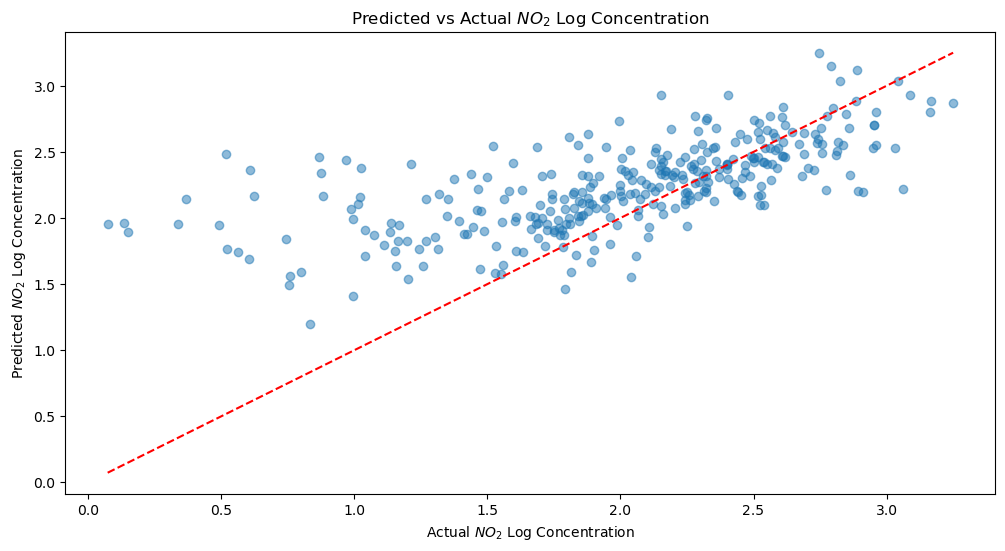

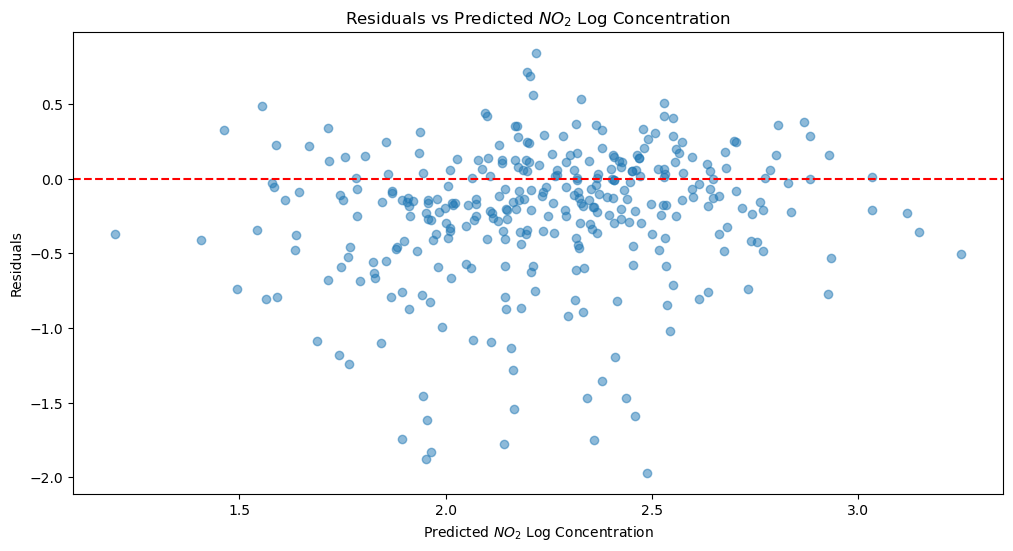

In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
# Print the results
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(r'Predicted vs Actual $NO_2$ Log Concentration')
plt.xlabel(r'Actual $NO_2$ Log Concentration')
plt.ylabel(r'Predicted $NO_2$ Log Concentration')
plt.show()

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(r'Residuals vs Predicted $NO_2$ Log Concentration')
plt.xlabel(r'Predicted $NO_2$ Log Concentration')
plt.ylabel('Residuals')
plt.show()


Mean of training data: 2.436
Mean of predicted difference: 0.239
Median of predicted difference: 0.161


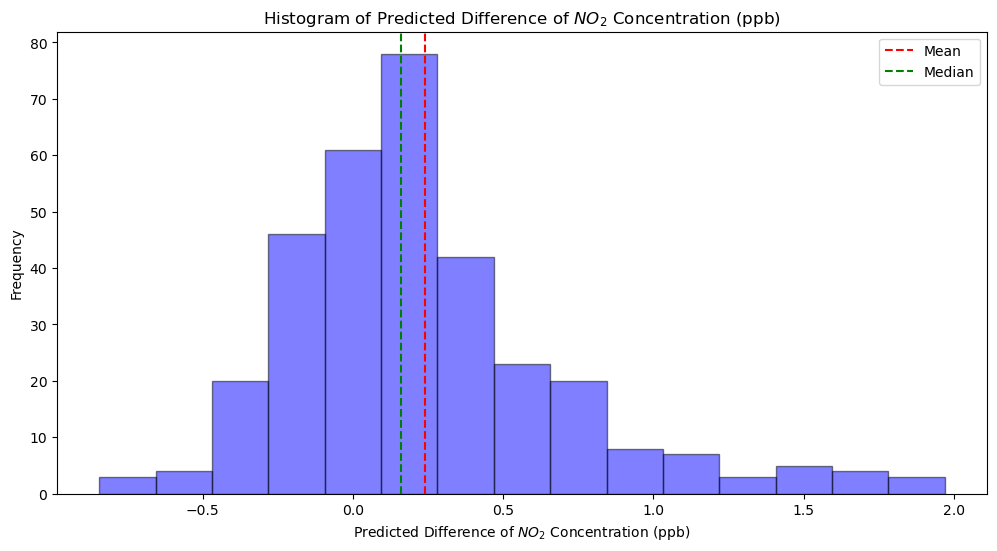

In [ ]:
# Calculate the mean of the training data
mean_train = y_train.mean()
# Print the mean of the training data
print(f'Mean of training data: {mean_train:.3f}')

# Calculate the predicted difference
predicted_difference = y_pred - y_test
# Create a DataFrame for the predicted vs actual values
predicted_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'predicted_difference': predicted_difference})
# Sort the index of the dataframes

# Calculate the mean and median of the predicted difference
mean_predicted_difference = predicted_difference.mean()
median_predicted_difference = predicted_difference.median()
# Print the mean and median of the predicted difference
print(f'Mean of predicted difference: {mean_predicted_difference:.3f}')
print(f'Median of predicted difference: {median_predicted_difference:.3f}')

# Plot a histogram of the predicted difference
plt.figure(figsize=(12, 6))
plt.hist(predicted_difference, bins=15, alpha=0.5, color='blue', edgecolor='black')
plt.title(r'Histogram of Predicted Difference of $NO_2$ Concentration (ppb)')
plt.xlabel(r'Predicted Difference of $NO_2$ Concentration (ppb)')
plt.ylabel('Frequency')
plt.axvline(predicted_difference.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(predicted_difference.median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.show()


In [25]:
# Test for normality of the difference
from scipy import stats
# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(predicted_difference)
print(f'Shapiro-Wilk test statistic: {shapiro_test.statistic:.3f}, p-value: {shapiro_test.pvalue:.3f}')


Shapiro-Wilk test statistic: 0.921, p-value: 0.000


In [ ]:
# Calculate the 95% confidence interval for the mean of the predicted difference
import statsmodels.api as sm
import statsmodels.stats.api as sms
# Calculate the mean and standard error of the mean
mean_diff = predicted_difference.mean()
sem_diff = stats.sem(predicted_difference)
# Calculate the confidence interval
confidence_interval = sms.DescrStatsW(predicted_difference).tconfint_mean()
print(f'95% confidence interval for the mean of the predicted difference: ')
print(confidence_interval)


95% confidence interval for the mean of the predicted difference: 
(0.18830334801323168, 0.2891796627891977)


### Model Fitting by Metro Area

In [27]:
# Dataframe for the modeling results
model_results = []

# Repeat the analysis in a loop for all the metro areas
for metro_area in metro_areas:
    # Filter the data for the current metro area
    metro_data = merged_data[merged_data['metro_area'] == metro_area]
    # Select feature of the model to train
    model_data = metro_data[features]
    # Fill the missing values with interpolation
    model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')
    
    # Drop na values
    model_data = model_data.dropna()

    # Print the shape of the data
    #print(f'Metro area: {metro_area}')
    #print(f'Metro area data shape: {model_data.shape}')

    # Split the data into training and testing sets
    train_data = model_data[model_data['COVID'] == 'Pre-COVID']
    test_data = model_data[model_data['COVID'] == 'Post-COVID']

    # Identify which fips_site values are in the test data but not in the training data
    fips_sites_test = test_data['fips_site'].unique()
    fips_sites_train = train_data['fips_site'].unique()
    fips_sites_diff = set(fips_sites_test) - set(fips_sites_train)
    #print(f'Fips sites in test data but not in training data: {fips_sites_diff}')

    # Drop all rows with fips_site values in the test data but not in the training data
    test_data = test_data[~test_data['fips_site'].isin(fips_sites_diff)]

    y_train = train_data[dependent_variable]
    X_train = train_data[features].drop(columns=[dependent_variable, 'COVID'])

    y_test = test_data[dependent_variable]
    X_test = test_data[features].drop(columns=[dependent_variable, 'COVID'])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    # Calculate the mean squared error and R-squared score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Print the results

    # Calculate the predicted difference
    predicted_difference = y_pred - y_test

    # Calculate the mean of the predicted difference
    mean_diff = predicted_difference.mean()
    # Calculate the standard error of the mean
    sem_diff = stats.sem(predicted_difference)
    # Calculate the confidence interval
    confidence_interval = sms.DescrStatsW(predicted_difference).tconfint_mean()
    mean_diff_ci_lower = confidence_interval[0]
    mean_diff_ci_upper = confidence_interval[1]

    # Add the results to the dataframe
    model_results.append([
        metro_area,
        mse,
        r2,
        mean_diff,
        mean_diff_ci_lower,
        mean_diff_ci_upper
    ])

# Create a dataframe for the model results
model_results_df = pd.DataFrame(model_results, columns=[
    'metro_area',
    'mean_squared_error',
    'r_squared',
    'mean_difference',
    'mean_difference_ci_lower',
    'mean_difference_ci_upper'
])

# Print the model results
print(model_results_df)

# Show the model results as a table
show(model_results_df)


    metro_area  mean_squared_error  r_squared  mean_difference  \
0      Chicago                0.27       0.27             0.24   
1       Denver                0.15       0.78             0.19   
2  Los Angeles                0.18       0.64             0.12   
3     New York                0.21       0.17             0.22   
4   Washington                0.28       0.30             0.31   

   mean_difference_ci_lower  mean_difference_ci_upper  
0                      0.19                      0.29  
1                      0.17                      0.20  
2                      0.11                      0.13  
3                      0.18                      0.26  
4                      0.28                      0.33  


# Average by week and fit the model

In [ ]:
# Average all the merged data by fips, fips_site, metro_area year, and week_of_year
merged_data_weekly = merged_data.copy()
merged_data_weekly= merged_data_weekly.groupby(['fips', 'fips_site', 'metro_area', 'year', 'week_of_year'], observed=True).agg(
    {'NO2_concentration': 'mean', 
     'outdoor_temperature': 'mean',
     'relative_humidity': 'mean',
     'wind_direction': 'mean',
     'wind_speed': 'mean'}).reset_index()

# Convert week of year to numeric
merged_data_weekly['week_of_year'] = pd.to_numeric(merged_data_weekly['week_of_year'], errors='coerce')

# Create a column for year and week_of_year
merged_data_weekly['year_week'] = merged_data_weekly['year'].astype(str) + '-' + merged_data_weekly['week_of_year'].astype(str)

# Take the log of the NO2 concentrations and wind speed
merged_data_weekly['NO2_log'] = np.log(merged_data_weekly['NO2_concentration'])
merged_data_weekly['wind_speed_log'] = np.log(merged_data_weekly['wind_speed'])

# Add a column for the day of the year as a sin function
merged_data_weekly['week_of_year_sin'] = np.sin(2 * np.pi * merged_data_weekly['week_of_year'] / 52.0)
# Add a column for the day of the year as a cos function
merged_data_weekly['week_of_year_cos'] = np.cos(2 * np.pi * merged_data_weekly['week_of_year'] / 52.0)

# Set the date_local as the index
merged_data_weekly.set_index('year_week', inplace=True)
# Sort the index of the dataframe
merged_data_weekly.sort_index(inplace=True)


<Axes: >

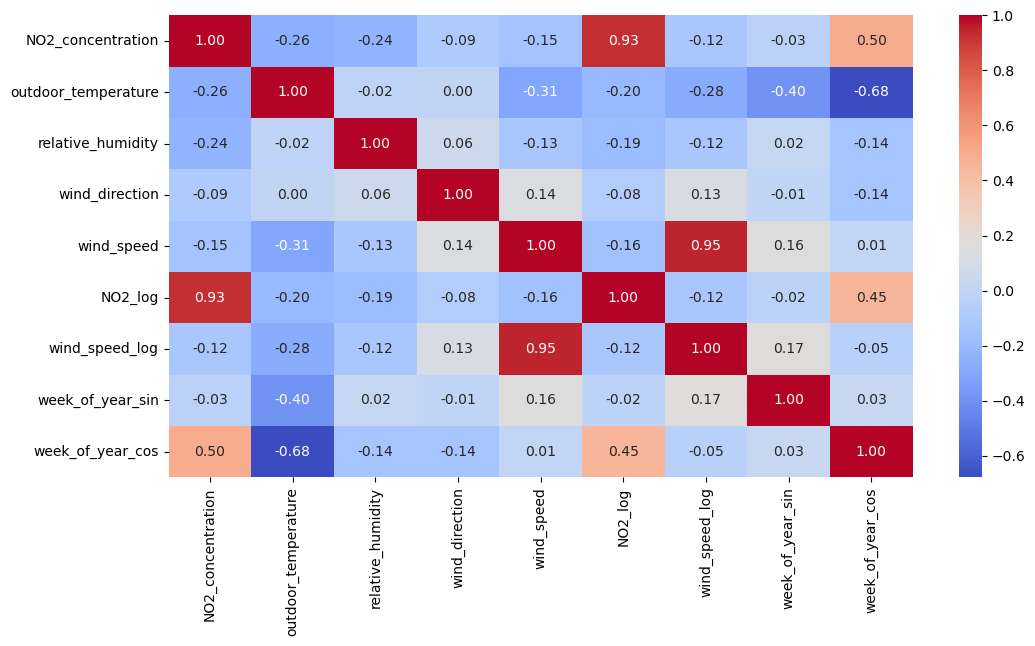

In [ ]:
# Correlation matrix
corr_data = merged_data_weekly.drop(columns=['fips', 'fips_site', 'metro_area', 'year', 'week_of_year'])
corr = corr_data.corr()
# Plot the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')


### Weekly Average Fit Model

In [ ]:
# Dependent variable:
dependent_variable = 'NO2_log'

features = [dependent_variable, 
            'fips_site', 
            'week_of_year_sin', 'week_of_year_cos',
            'outdoor_temperature', 
            'relative_humidity',
            'wind_direction', 'wind_speed_log'
            ]

# Define the column transformer
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['fips_site']),
    ],
    remainder='passthrough'  # keep other columns
)

# Create a pipeline for the model
pipeline = Pipeline(steps=[
    ('preprocessor', transformer),
    ('scaler', StandardScaler(with_mean=False)),
    ('model', LinearRegression())
    #('model', RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True))
    #('model', LassoCV(alphas=[0.1, 1.0, 10.0], cv=5, random_state=998))
    #('model', ElasticNetCV(alphas=[0.1, 1.0, 10.0], cv=5, random_state=998))
])


Missing values in each feature:
Series([], dtype: int64)
Model data shape: (346, 8)
Training data shape: (276, 7)
Testing data shape: (70, 7)
Training target shape: (276,)
Testing target shape: (70,)
Mean Squared Error: 0.047
Root Mean Squared Error: 0.217
R-squared: 0.678


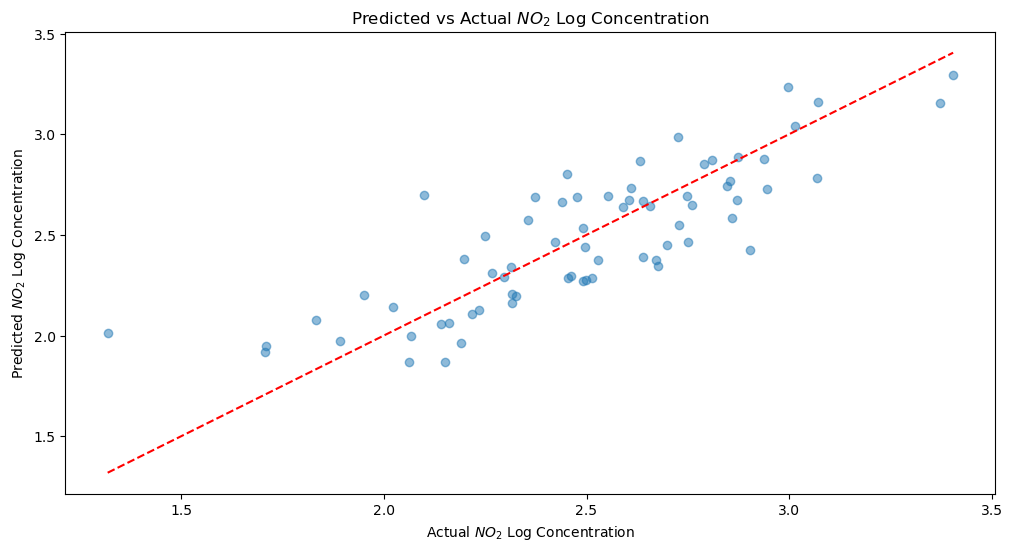

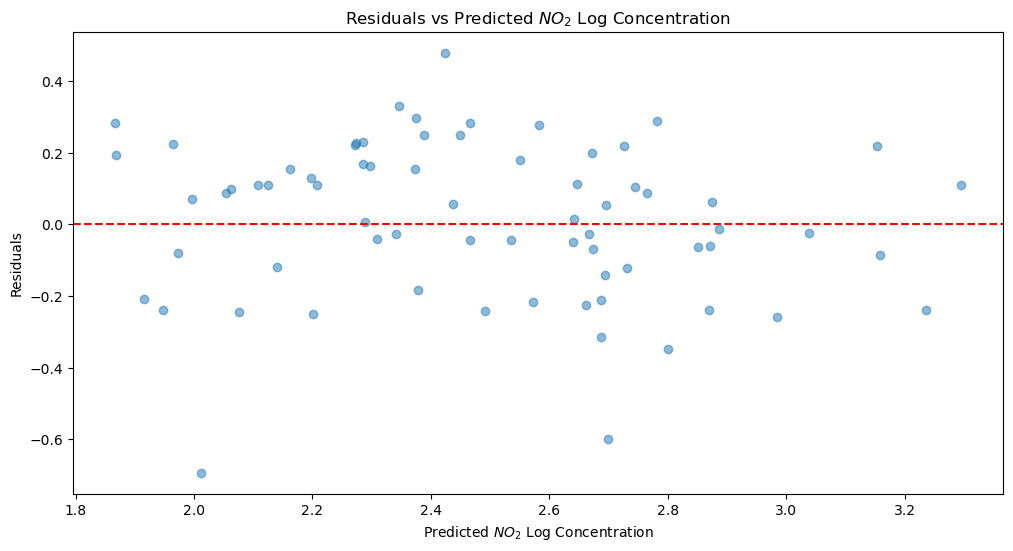

In [ ]:
metro_area_of_interest = 'Chicago'

merged_data_metro = merged_data_weekly[merged_data_weekly['metro_area'] == metro_area_of_interest]
model_data = merged_data_metro.copy()
model_data = model_data[model_data['year'] <= 2019]

# Select feature of the model to train
model_data = model_data[features]

# Fill the missing values with interpolation
model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')

# Count the number of rows with missing values
missing_values = model_data.isnull().sum()

# Print the number of missing values for each feature
print('Missing values in each feature:')
print(missing_values[missing_values > 0])

# Drop na values
model_data = model_data.dropna()

# Print the size of the model data
print(f'Model data shape: {model_data.shape}')

# Select the dependent variable and independent variables
Y = model_data[dependent_variable]
X = model_data[features].drop(columns=[dependent_variable])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=998)

# Check the training and testing data shapes
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Training target shape: {y_train.shape}')
print(f'Testing target shape: {y_test.shape}')

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
# Calculate the mean squared error 
mse = mean_squared_error(y_test, y_pred)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
# Print the results
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(r'Predicted vs Actual $NO_2$ Log Concentration')
plt.xlabel(r'Actual $NO_2$ Log Concentration')
plt.ylabel(r'Predicted $NO_2$ Log Concentration')
plt.show()

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(r'Residuals vs Predicted $NO_2$ Log Concentration')
plt.xlabel(r'Predicted $NO_2$ Log Concentration')
plt.ylabel('Residuals')
plt.show()


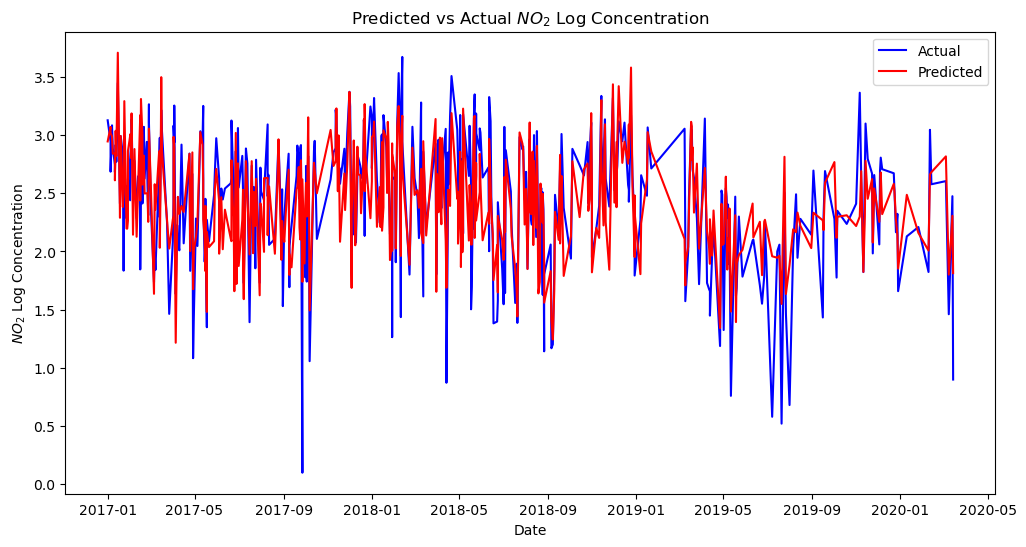

In [ ]:
# Sort the index of the dataframes
y_pred_df.sort_index(inplace=True)
y_test_df.sort_index(inplace=True)

# Time series plot of predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_df.index, y_test_df, label='Actual', color='blue')
plt.plot(y_pred_df.index, y_pred_df['y_pred'], label='Predicted', color='red')
plt.title(r'Predicted vs Actual $NO_2$ Log Concentration')
plt.xlabel('Date')
plt.ylabel(r'$NO_2$ Log Concentration')
plt.legend()
plt.show()


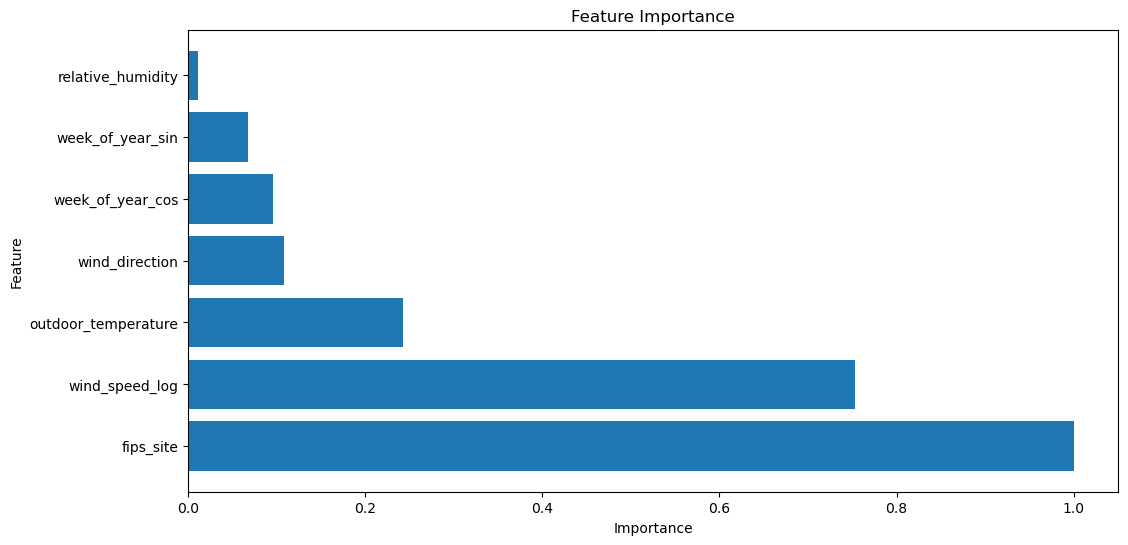

In [ ]:
# Calculate the Feature Importance
from sklearn.inspection import permutation_importance
# Calculate the feature importance using permutation importance
result = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=998)
# Get the feature names
feature_names = X_test.columns
# Create a DataFrame for the feature importance
importance_df = pd.DataFrame(result.importances_mean, index=feature_names, columns=['Importance'])
# Sort the feature importance
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df.index, importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### Weekly Averaged Data Fitting Model

In [ ]:
# Dataframe for the modeling results
model_results = []

# Repeat the analysis in a loop for all the metro areas
for metro_area in metro_areas:
    print(f'\n\nMetro Area: {metro_area}')
    # Filter the data for the current metro area
    metro_data = merged_data_weekly[merged_data_weekly['metro_area'] == metro_area]
    # Filter only the pre-COVID data
    metro_data = metro_data[metro_data['year'] <= 2019]

    # Select feature of the model to train
    model_data = metro_data[features]

    # Fill the missing values with interpolation
    model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')

    # Count the number of rows with missing values
    missing_values = model_data.isnull().sum()
    # Print the number of missing values for each feature
    print('Missing values in each feature:')
    print(missing_values[missing_values > 0])

    # Drop na values
    model_data = model_data.dropna()

    # Print the size of the model data
    print(f'Model data shape: {model_data.shape}')

    # Select the dependent variable and independent variables
    Y = model_data[dependent_variable]
    X = model_data[features].drop(columns=[dependent_variable])
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=998)

    # Check the training and testing data shapes
    print(f'Training data shape: {X_train.shape}')
    print(f'Testing data shape: {X_test.shape}')
    print(f'Training target shape: {y_train.shape}')
    print(f'Testing target shape: {y_test.shape}')

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append the results to the model results list
    model_results.append({
        'Metro Area': metro_area,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })
    # Create a DataFrame for the model results
    model_results_df = pd.DataFrame(model_results)

# Print the model results
print(model_results_df)

# Show the model results as a table
show(model_results_df)




Metro Area: Chicago
Missing values in each feature:
Series([], dtype: int64)
Model data shape: (346, 8)
Training data shape: (276, 7)
Testing data shape: (70, 7)
Training target shape: (276,)
Testing target shape: (70,)


Metro Area: Denver
Missing values in each feature:
Series([], dtype: int64)
Model data shape: (863, 8)
Training data shape: (690, 7)
Testing data shape: (173, 7)
Training target shape: (690,)
Testing target shape: (173,)


Metro Area: Los Angeles
Missing values in each feature:
Series([], dtype: int64)
Model data shape: (2363, 8)
Training data shape: (1890, 7)
Testing data shape: (473, 7)
Training target shape: (1890,)
Testing target shape: (473,)


Metro Area: New York
Missing values in each feature:
relative_humidity    9
dtype: int64
Model data shape: (965, 8)
Training data shape: (772, 7)
Testing data shape: (193, 7)
Training target shape: (772,)
Testing target shape: (193,)


Metro Area: Washington
Missing values in each feature:
Series([], dtype: int64)
Model 

In [ ]:
model_data = merged_data_weekly.copy()

model_data = model_data[model_data['metro_area'] == metro_area_of_interest]

# Filter the data for the dependent variable and independent variables
features = [dependent_variable, 
            'fips_site',
            'year', 
            'week_of_year_sin', 'week_of_year_cos',
            'outdoor_temperature', 
            'relative_humidity',
            'wind_direction', 'wind_speed_log'
            ]

# Select feature of the model to train
model_data = model_data[features]

# Fill the missing values with interpolation
model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')

# Drop na values
model_data = model_data.dropna()


In [ ]:
# Split the data into training and testing sets
train_data = model_data[model_data['year'] <= 2019]
test_data = model_data[model_data['year'] == 2020]

# Identify which fips_site values are in the test data but not in the training data
fips_sites_test = test_data['fips_site'].unique()
fips_sites_train = train_data['fips_site'].unique()
fips_sites_diff = set(fips_sites_test) - set(fips_sites_train)
print(f'Fips sites in test data but not in training data: {fips_sites_diff}')

# Drop all rows with fips_site values in the test data but not in the training data
test_data = test_data[~test_data['fips_site'].isin(fips_sites_diff)]

# Identify which fips_site values are in the test data but not in the training data
fips_sites_test = test_data['fips_site'].unique()
fips_sites_train = train_data['fips_site'].unique()
fips_sites_diff = set(fips_sites_test) - set(fips_sites_train)
print(f'Fips sites in test data but not in training data: {fips_sites_diff}')

y_train = train_data[dependent_variable]
X_train = train_data[features].drop(columns=[dependent_variable, 'year'])

y_test = test_data[dependent_variable]
X_test = test_data[features].drop(columns=[dependent_variable, 'year'])

# Print the shape of the data
print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

print(f'Train data shape: {y_train.shape}')
print(f'Test data shape: {y_test.shape}')


Fips sites in test data but not in training data: {'55059_0019'}
Fips sites in test data but not in training data: set()
Train data shape: (346, 7)
Test data shape: (51, 7)
Train data shape: (346,)
Test data shape: (51,)


Mean Squared Error: 0.140
Root Mean Squared Error: 0.374
R-squared: -0.192


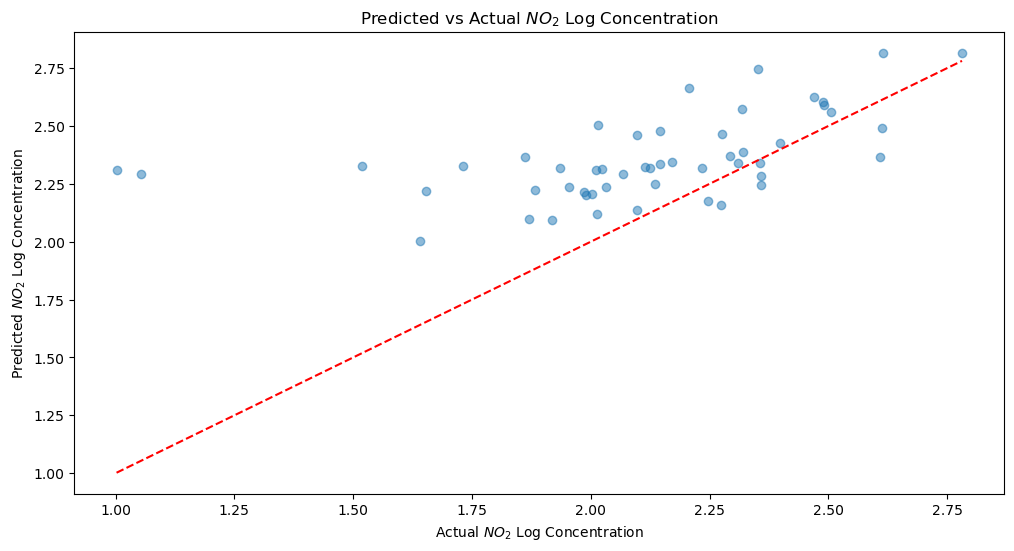

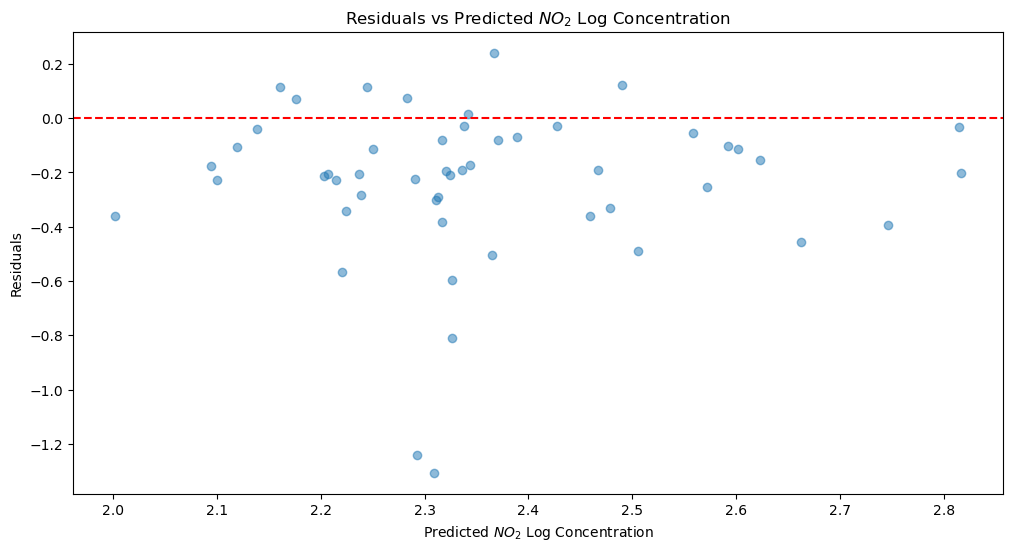

In [ ]:
# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
# Calculate the root mean squared error
rmse = np.sqrt(mse)
# Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
# Print the results
print(f'Mean Squared Error: {mse:.3f}')
print(f'Root Mean Squared Error: {rmse:.3f}')
print(f'R-squared: {r2:.3f}')

# Plot the predicted vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(r'Predicted vs Actual $NO_2$ Log Concentration')
plt.xlabel(r'Actual $NO_2$ Log Concentration')
plt.ylabel(r'Predicted $NO_2$ Log Concentration')
plt.show()

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title(r'Residuals vs Predicted $NO_2$ Log Concentration')
plt.xlabel(r'Predicted $NO_2$ Log Concentration')
plt.ylabel('Residuals')
plt.show()


Mean of training data: 2.512
Mean of predicted difference: 0.238
Median of predicted difference: 0.202


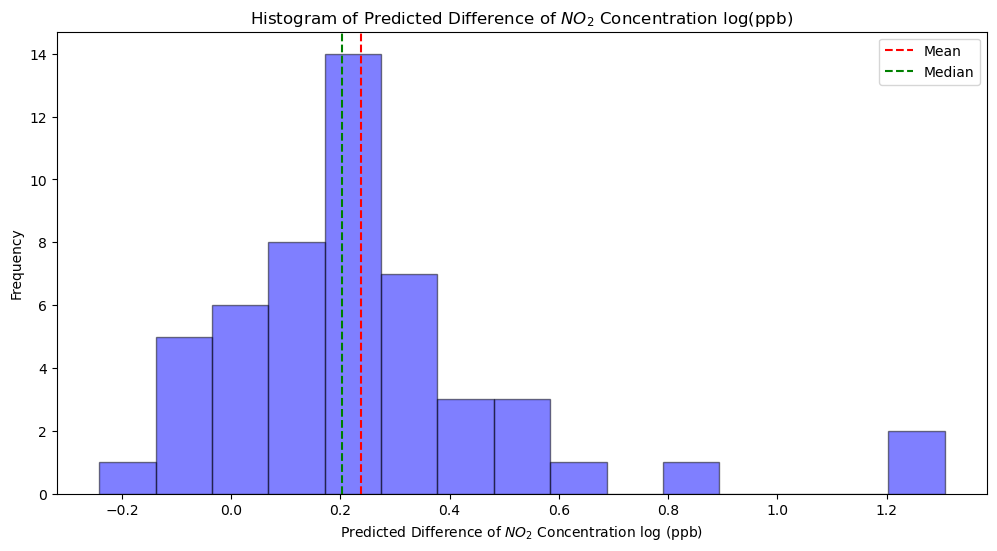

In [ ]:
# Calculate the mean of the training data
mean_train = y_train.mean()
# Print the mean of the training data
print(f'Mean of training data: {mean_train:.3f}')

# Calculate the predicted difference
predicted_difference = y_pred - y_test
# Create a DataFrame for the predicted vs actual values
predicted_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'predicted_difference': predicted_difference})
# Sort the index of the dataframes

# Calculate the mean and median of the predicted difference
mean_predicted_difference = predicted_difference.mean()
median_predicted_difference = predicted_difference.median()
# Print the mean and median of the predicted difference
print(f'Mean of predicted difference: {mean_predicted_difference:.3f}')
print(f'Median of predicted difference: {median_predicted_difference:.3f}')

# Plot a histogram of the predicted difference
plt.figure(figsize=(12, 6))
plt.hist(predicted_difference, bins=15, alpha=0.5, color='blue', edgecolor='black')
plt.title(r'Histogram of Predicted Difference of $NO_2$ Concentration log(ppb)')
plt.xlabel(r'Predicted Difference of $NO_2$ Concentration log (ppb)')
plt.ylabel('Frequency')
plt.axvline(predicted_difference.mean(), color='red', linestyle='--', label='Mean')
plt.axvline(predicted_difference.median(), color='green', linestyle='--', label='Median')
plt.legend()
plt.show()


In [ ]:
# Calculate the 95% confidence interval for the mean of the predicted difference
import statsmodels.api as sm
import statsmodels.stats.api as sms
# Calculate the mean and standard error of the mean
mean_diff = predicted_difference.mean()
sem_diff = stats.sem(predicted_difference)
# Calculate the confidence interval
confidence_interval = sms.DescrStatsW(predicted_difference).tconfint_mean()
print(f'95% confidence interval for the mean of the predicted difference: ')
print(confidence_interval)


95% confidence interval for the mean of the predicted difference: 
(0.15657037132854423, 0.3202572220821721)


### Run the Weekly Average Model on all Metro Areas

In [ ]:
# Dataframe for the modeling results
model_results = []

features = [dependent_variable, 
            'fips_site',
            'year', 
            'week_of_year_sin', 'week_of_year_cos',
            'outdoor_temperature', 
            'relative_humidity',
            'wind_direction', 'wind_speed_log'
            ]

# Repeat the analysis in a loop for all the metro areas
for metro_area in metro_areas:
    # Filter the data for the current metro area
    metro_data = merged_data_weekly[merged_data_weekly['metro_area'] == metro_area]
    # Select feature of the model to train
    model_data = metro_data[features]
    # Fill the missing values with interpolation
    model_data=model_data.interpolate(method='linear', limit=7, limit_direction='both')
    
    # Drop na values
    model_data = model_data.dropna()

    # Print the shape of the data
    #print(f'Metro area: {metro_area}')
    #print(f'Metro area data shape: {model_data.shape}')

    # Split the data into training and testing sets
    train_data = model_data[model_data['year'] <= 2019]
    test_data = model_data[model_data['year'] == 2020]

    # Identify which fips_site values are in the test data but not in the training data
    fips_sites_test = test_data['fips_site'].unique()
    fips_sites_train = train_data['fips_site'].unique()
    fips_sites_diff = set(fips_sites_test) - set(fips_sites_train)
    #print(f'Fips sites in test data but not in training data: {fips_sites_diff}')

    # Drop all rows with fips_site values in the test data but not in the training data
    test_data = test_data[~test_data['fips_site'].isin(fips_sites_diff)]

    y_train = train_data[dependent_variable]
    X_train = train_data[features].drop(columns=[dependent_variable, 'year'])

    y_test = test_data[dependent_variable]
    X_test = test_data[features].drop(columns=[dependent_variable, 'year'])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    # Calculate the mean squared error and R-squared score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Print the results

    # Calculate the predicted difference
    predicted_difference = y_pred - y_test

    # Calculate the mean of the predicted difference
    mean_diff = predicted_difference.mean()
    # Calculate the standard error of the mean
    sem_diff = stats.sem(predicted_difference)
    # Calculate the confidence interval
    confidence_interval = sms.DescrStatsW(predicted_difference).tconfint_mean()
    mean_diff_ci_lower = confidence_interval[0]
    mean_diff_ci_upper = confidence_interval[1]

    # Add the results to the dataframe
    model_results.append([
        metro_area,
        mse,
        r2,
        mean_diff,
        mean_diff_ci_lower,
        mean_diff_ci_upper
    ])

# Create a dataframe for the model results
model_results_df = pd.DataFrame(model_results, columns=[
    'metro_area',
    'mean_squared_error',
    'r_squared',
    'mean_difference',
    'mean_difference_ci_lower',
    'mean_difference_ci_upper'
])

# Print the model results
print(model_results_df)

# Show the model results as a table
show(model_results_df)


    metro_area  mean_squared_error  r_squared  mean_difference  \
0      Chicago                0.14      -0.19             0.24   
1       Denver                0.09       0.87             0.18   
2  Los Angeles                0.09       0.72             0.12   
3     New York                0.09       0.40             0.18   
4   Washington                0.17       0.30             0.29   

   mean_difference_ci_lower  mean_difference_ci_upper  
0                      0.16                      0.32  
1                      0.16                      0.21  
2                      0.10                      0.14  
3                      0.14                      0.23  
4                      0.25                      0.34  
